In [4]:
import pandas as pd
import gpxpy
import gpxpy.gpx
import geopy.distance

In [5]:
# Loads gpx file and returns data frame run
def load_run_to_df(filename): 
    
    # Load file into run_data using gpxpy
    with open(filename) as f:
        run_data = gpxpy.parse(f)
    f.closed
    
    # Initialize DataFrames
    df_dict = {'time': [],'lat': [],'lon': [],'elev': []}
    df = pd.DataFrame(df_dict)
    
    
    # Create DataFrame containing time, latitude, longitude, elevation columns
    for track in run_data.tracks:
        for segment in track.segments:
            for point in segment.points:
                df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','lat','lon','elev'])
                df = df.append(df_newRow, ignore_index=True)
                
    # Create additional column for accumulative distance
    tmp = [0]
    for i, row in df[1:].iterrows():
        prevCoord = (df.iloc[i-1]['lat'],df.iloc[i-1]['lon'])
        currCoord = (df.iloc[i]['lat'],df.iloc[i]['lon'])
        tmp.append(tmp[-1] + geopy.distance.vincenty(prevCoord, currCoord).mi)
    df['accuDist']=tmp
    
    return df

df = load_run_to_df('RK_gpx _2018-05-19_0757.gpx')

In [6]:
df.head()

,elev,lat,lon,time,accuDist
0,23.0,37.447922,-122.183063,2018-05-19 14:57:00,0.000000
1,23.0,37.447878,-122.183106,2018-05-19 14:57:04,0.003847
2,23.0,37.447780,-122.183102,2018-05-19 14:57:13,0.010609
3,23.0,37.447717,-122.182983,2018-05-19 14:57:17,0.018463
4,23.0,37.447663,-122.182879,2018-05-19 14:57:21,0.025287


In [7]:
# Calculate total distance, total time of this run
total_distance = df.iloc[-1]['accuDist']    
print('Total distance: \t%.2f mi' % total_distance)

Total distance: 	15.56 mi


In [8]:
# Calculate total time of this run
from time import strftime

def strfdelta(tdelta, fmt): # Reformats timedelta object to h:mm:ss
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

total_time = df.iloc[-1]['time']-df.iloc[0]['time'] # creates timedelta object

print('Total time: \t%s' % strfdelta(total_time, "{hours}:{minutes}:{seconds}"))

Total time: 	2:22:50


In [9]:
# Calculate average pace
avg_pace = total_time.seconds / total_distance
avg_pace_min, avg_pace_sec = divmod(avg_pace, 60)
print('Average pace: \t%d:%d per mi' % (avg_pace_min, avg_pace_sec))

Average pace: 	9:10 per mi


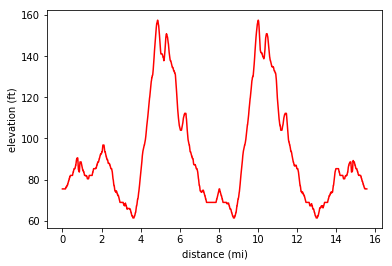

Total climb: 	321.2


In [10]:
# Plot height profile and calculate total climb
import matplotlib.pyplot as plt

plt.plot(df['accuDist'],3.28084*df['elev'], 'r')
#plt.plot(realTimeAxis[:-bins],profileDer, 'b')
plt.ylabel('elevation (ft)')
plt.xlabel('distance (mi)')
plt.show()


# Calculate total climb as sum of positive inclines between two waypoints
total_climb=0
for i, row in df[1:].iterrows():
    height_difference = 3.28084*(df.iloc[i]['elev'] - df.iloc[i-1]['elev'])
    if height_difference>0:
        total_climb += height_difference

print('Total climb: \t%.1f' % total_climb)

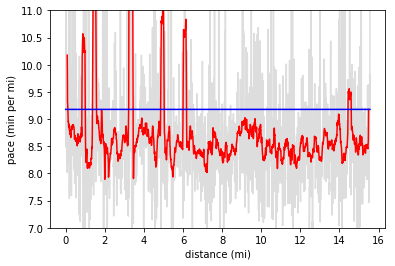

In [11]:
# Calculate current pace
import numpy as np
import copy

# pace_hist is a list of paces between two points each
pace_hist=[]
for i, row in df[1:].iterrows():
    time_diff = df.iloc[i]['time']-df.iloc[i-1]['time']
    pos_diff  = df.iloc[i]['accuDist']-df.iloc[i-1]['accuDist']
    curr_pace = time_diff.seconds / pos_diff
    pace_hist.append(curr_pace/60)
    
# remove spikes (if a value is more than spike_tolerace times larger than the mean of the surrounding values)
spike_tolerance = 1.3
pace_hist_nospikes = copy.copy(pace_hist)
for i in range(len(pace_hist_nospikes)):
    if i>1 and i<(len(pace_hist_nospikes)-2):
        if pace_hist_nospikes[i] > spike_tolerance * np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i-1],pace_hist_nospikes[i+1],pace_hist_nospikes[i+2]]):
            pace_hist_nospikes[i] = np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i+2]])
        
        
# running average of pace (without spikes), N is width of average    
N = 23 # N must be 2n+1
pace_hist_binned = np.convolve(pace_hist_nospikes, np.ones((N,))/N, mode='valid')
    
# Plot original pace trace in grey and spike-removed, averaged trace in red
plt.plot(df['accuDist'][1:],pace_hist,'#dddddd')
plt.plot(df['accuDist'][1+int((N-1)/2):-int((N-1)/2)],pace_hist_binned,'r')
plt.plot(df['accuDist'][1:],[avg_pace/60 for i in range(len(df['accuDist'][1:]))],'b')
plt.ylabel('pace (min per mi)')
plt.xlabel('distance (mi)')
plt.ylim(7,11)
#plt.xlim(2,4)
plt.show()


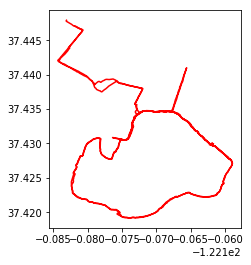

In [12]:
# Plot running path
plt.plot(df['lon'],df['lat'],'r')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()